# Custom Decoding and Padding

## Methods

In [1]:
import soundfile as sf
import librosa
import numpy as np

def load_audio(sample, min_len: float, max_len: float, sampling_rate: int, pad_to_min_length: bool = False):
    """ 
    Decodes audio from sample file into a waveform with the given
    `sampling rate` and a length in the intervall `[min_len, max_len]`.
    The exception to this is when the file of a sample is shorter
    than `min_len` and `pad_to_min_len` isn't set. In this case the
    returned audio will be the whole file.  
    If `pad_to_min_len` is set and a file is shorter than `min_len`
    then the returned audio will be symmetrically padded to `min_len`
    with its mean.

    Returns:
        Tuple: A tuple of audio waveform and sampling rate
    """

    path = sample["filepath"]

    file_info = sf.info(path)
    sr = file_info.samplerate
    total_duration = file_info.duration

    # convert all time information into sample index information for better accuracy
    original_min_len = min_len
    total_duration = int(total_duration * sr)
    min_len = int(min_len * sr)
    max_len = int(max_len * sr)


    if sample["detected_events"] is not None:
        start = int(sample["detected_events"][0] * sr)
        end = int(sample["detected_events"][1] * sr)
        event_duration = end - start

        if event_duration < min_len:
            extension = (min_len - event_duration) // 2
            
            # try to extend equally 
            new_start = max(0, start - extension)
            new_end = min(total_duration, end + extension)
            
            # check whether extending equally was successful
            if new_end - new_start < min_len:
                if new_end < total_duration:
                    # shift new_end further to a point where min_len is reached
                    new_end = min(total_duration, new_end + (min_len - (new_end - new_start)))
                if new_start > 0:
                    # shift new_start back to a point where min_len is reached
                    new_start = max(0, new_start - (min_len - (new_end - new_start)))

            start, end = new_start, new_end


        if end - start > max_len:
            # if longer than max_len
            end = min(start + max_len, total_duration)
            if end - start > max_len:
                end = start + max_len
    else:
        start = int(sample["start_time"] * sr)
        end = int(sample["end_time"] * sr)

        # cut audio if it's over max_len
        if (end - start) > max_len:
            to_cut = (end - start) - max_len
            equal_cut = to_cut // 2

            start += equal_cut
            end -= equal_cut

            # possible cutting needed due to integer division
            cut_left = (end - start) - max_len
            end -= cut_left


    audio, sr = sf.read(path, start=start, stop=end, dtype="float32")

    if audio.ndim != 1:
        audio = audio.swapaxes(1, 0)
        audio = librosa.to_mono(audio)
    if sr != sampling_rate:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=sampling_rate)
        sr = sampling_rate

    if (((end - start) < min_len) or total_duration < min_len) and pad_to_min_length:
        audio = pad_audio(audio, sr, original_min_len)

    return audio, sr


def pad_audio(audio, sample_rate: int, wanted_length: float):
    """
    Pads the given `audio` waveform to the `wanted_length` symmetrically
    with its mean.

    Returns:
        NDArray: padded audio waveform
    """
    len_to_pad = int(wanted_length * sample_rate - audio.size)

    if len_to_pad <= 0:
        return audio

    # divide padding into equal parts
    left_pad = len_to_pad // 2
    right_pad = len_to_pad // 2

    # make sure it is padded to the right size
    if left_pad + right_pad != len_to_pad:
        right_pad = right_pad + (len_to_pad - (left_pad + right_pad))
    return np.pad(audio, [(left_pad, right_pad)], mode=("mean" if audio.size != 0 else "empty"))

## Testing

In [10]:
import datasets 

dataset = datasets.load_from_disk(dataset_path="/home/rantjuschin/bachelor-project/datasets/indexed/HSN")
train_set = dataset["train"]
dataset, train_set[0]

(DatasetDict({
     train: Dataset({
         features: ['filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist', 'genus', 'species_group', 'order', 'genus_multilabel', 'species_group_multilabel', 'order_multilabel', 'index'],
         num_rows: 38170
     })
     test: Dataset({
         features: ['filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist', 'genus', 'species_group', 'order', 'genus_multilabel', 'species_group_multilabel', 'order_multilabel', 'index'],
         num_rows: 10296
     })
     test_5s: Dataset({
        

[0.00242478 0.00209669 0.00244981 ... 0.00544281 0.01531514 0.02375999]
(160000,)


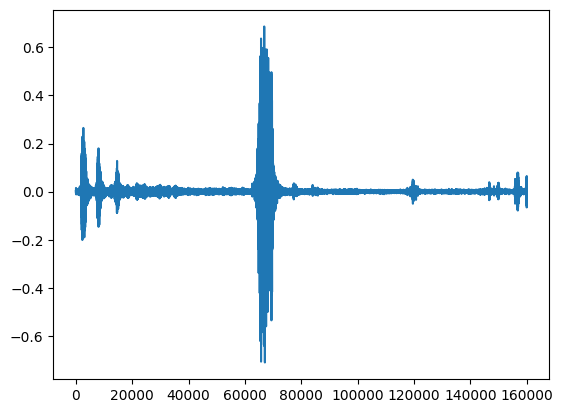

In [47]:
import matplotlib.pyplot as plt

decoded_batch, sr = load_audio(train_set[0], min_len=5, max_len=5, sampling_rate=32000, pad_to_min_length=True)
print(decoded_batch)
print(decoded_batch.shape)
plt.plot(decoded_batch)

## find padded sample

In [ ]:
for idx in range(len(train_set)):
    audio, sr = load_audio(train_set[idx], min_len=5, max_len=5, sampling_rate=32000, pad_to_min_length=False)
    if audio.shape[0] != 5*32000:
        print(idx, audio.shape)
        break

47 (140733,)


## test padded

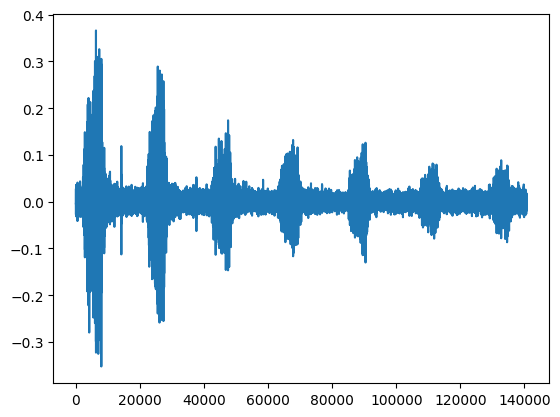

In [50]:
unpadded_audio, sr = load_audio(train_set[idx], min_len=5, max_len=5, sampling_rate=32000, pad_to_min_length=False)
plt.plot(unpadded_audio)

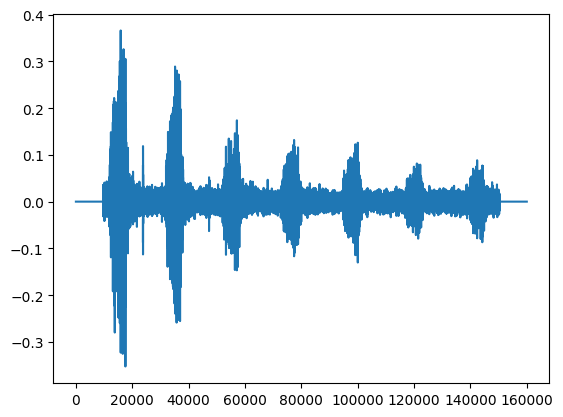

In [51]:
padded_audio, sr = load_audio(train_set[idx], min_len=5, max_len=5, sampling_rate=32000, pad_to_min_length=True)
plt.plot(padded_audio)

## BirdSet Decoding and Padding

### Decoding and Padding separately

{'filepath': ['/home/rantjuschin/data_birdset/HSN/downloads/extracted/e8d87da059276237fe3a09f216dfe50ac2186afa53bf9c3b9e14c93979cbeba4/XC805337.ogg'], 'start_time': [None], 'end_time': [None], 'low_freq': [None], 'high_freq': [None], 'ebird_code': [11], 'ebird_code_multilabel': [[11]], 'ebird_code_secondary': [['yellow2']], 'call_type': ['uncertain'], 'sex': ['female, male'], 'lat': [50.0927], 'long': [18.9176], 'length': [29], 'microphone': ['focal'], 'license': ['//creativecommons.org/licenses/by-nc-sa/4.0/'], 'source': ['xenocanto'], 'local_time': ['19:30'], 'detected_events': [[12.528, 13.632]], 'event_cluster': [[0]], 'peaks': [[12.678638560998488, 18.969645289822907, 21.799898317045177]], 'quality': ['A'], 'recordist': ['Ireneusz Oleksik'], 'genus': [1], 'species_group': [10], 'order': [0], 'genus_multilabel': [[1]], 'species_group_multilabel': [[10]], 'order_multilabel': [[0]], 'index': [0], 'audio': [{'path': '/home/rantjuschin/data_birdset/HSN/downloads/extracted/e8d87da059276

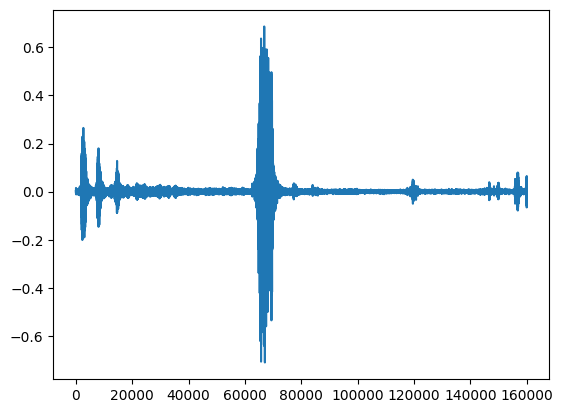

In [46]:
from birdset.datamodule.components.event_decoding import EventDecoding
from birdset.datamodule.components.feature_extraction import DefaultFeatureExtractor

decoder = EventDecoding(
    min_len=0,
    max_len=5,
    sampling_rate=32000,
    extension_time=5,
    extracted_interval=5
)

# calc mean
mean = 0

extractor = DefaultFeatureExtractor(
    feature_size=1,
    sampling_rate=32000,
    padding_value=mean,
    return_attention_mask=False
)

batch = {}
for key in train_set[0].keys():
    batch[key] = [train_set[0][key]]

decoded_batch = decoder(batch)
print(decoded_batch)
print(decoded_batch["audio"])

new_audio_attributes = []
for audio_attribute in decoded_batch["audio"]:
    new_audio_attributes.append(audio_attribute["array"])
decoded_batch["audio"] = new_audio_attributes
print(decoded_batch["audio"])


sample = extractor(decoded_batch["audio"], padding="max_length", max_length=5*32000, truncation=True, return_attention_mask=False)
print(sample)
print(sample["input_values"].shape)
plt.plot(sample["input_values"].squeeze())

#### test_padded

{'filepath': ['/home/rantjuschin/data_birdset/HSN/downloads/extracted/e8d87da059276237fe3a09f216dfe50ac2186afa53bf9c3b9e14c93979cbeba4/XC785353.ogg'], 'start_time': [None], 'end_time': [None], 'low_freq': [None], 'high_freq': [None], 'ebird_code': [11], 'ebird_code_multilabel': [[11]], 'ebird_code_secondary': [[]], 'call_type': ['call'], 'sex': [None], 'lat': [51.1567], 'long': [3.4577], 'length': [4], 'microphone': ['focal'], 'license': ['//creativecommons.org/licenses/by-nc-sa/4.0/'], 'source': ['xenocanto'], 'local_time': ['08:30'], 'detected_events': [[0.016, 0.944]], 'event_cluster': [[-1]], 'peaks': [[0.18925134475456898, 0.4432531496035017, 0.8181933137985675]], 'quality': ['A'], 'recordist': ['Valentijn Hermans'], 'genus': [1], 'species_group': [10], 'order': [0], 'genus_multilabel': [[1]], 'species_group_multilabel': [[10]], 'order_multilabel': [[0]], 'index': [47], 'audio': [{'path': '/home/rantjuschin/data_birdset/HSN/downloads/extracted/e8d87da059276237fe3a09f216dfe50ac2186

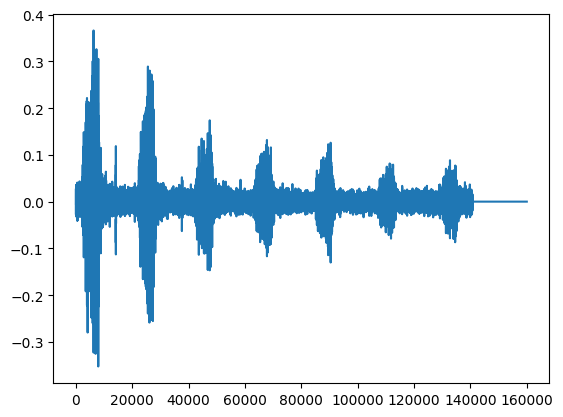

In [56]:
batch = {}
for key in train_set[47].keys():
    batch[key] = [train_set[47][key]]

decoded_batch = decoder(batch)
print(decoded_batch)
print(decoded_batch["audio"])

new_audio_attributes = []
for audio_attribute in decoded_batch["audio"]:
    new_audio_attributes.append(audio_attribute["array"])
decoded_batch["audio"] = new_audio_attributes
print(decoded_batch["audio"])

unpadded_sample = extractor(decoded_batch["audio"], padding=False, max_length=5*32000, truncation=True, return_attention_mask=False)
padded_sample = extractor(decoded_batch["audio"], padding="max_length", max_length=5*32000, truncation=True, return_attention_mask=False)
print(padded_sample)
print(padded_sample["input_values"].shape)
plt.plot(padded_sample["input_values"].squeeze())

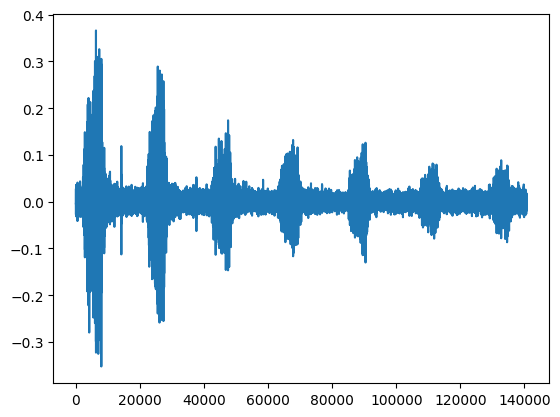

In [57]:
plt.plot(unpadded_sample["input_values"].squeeze())

## Decoding and Padding in TransformWrapper

In [58]:
from birdset.datamodule.components.transforms import BirdSetTransformsWrapper
from birdset.datamodule.components.event_decoding import EventDecoding
from birdset.datamodule.components.feature_extraction import DefaultFeatureExtractor

decoder = EventDecoding(
    min_len=0,
    max_len=5,
    sampling_rate=32000,
    extension_time=5,
    extracted_interval=5
)

#calc mean
mean = 0 

extractor = DefaultFeatureExtractor(
    feature_size=1,
    sampling_rate=32000,
    padding_value=mean,
    return_attention_mask=False
)

transforms = BirdSetTransformsWrapper(
    task="multilabel",
    sampling_rate=32000,
    model_type="vision",
    decoding=decoder,
    feature_extractor=extractor,
    max_length=5,
    nocall_sampler=None,
    preprocessing=None,
)

batch = {}
for key in train_set[0].keys():
    batch[key] = [train_set[0][key]]

sample = transforms(batch)
print(sample)
print(sample["input_values"].shape)
plt.plot(sample["input_values"].squeeze())

KeyError: 'labels'